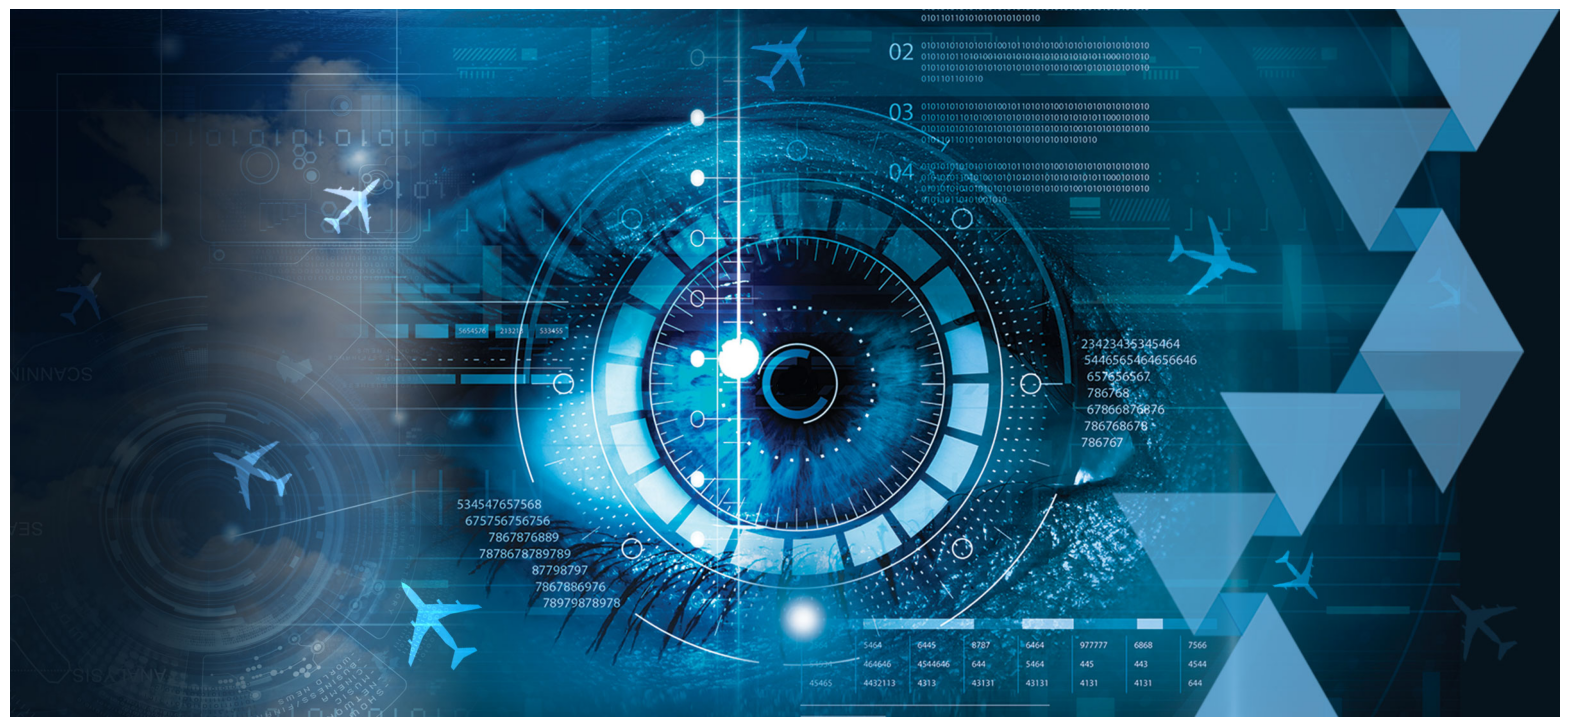

In [6]:
Imagen("IMAGENES\IA_0.jpg", (20,10))

# <h1 align=center> **CONECTIVIDAD AÉREA ARGENTINA** </h1>
-----------------------------------------------------

# <h1 align=center> **MLOPS - PREDICCIONES** </h1>
-------------------------------------------

# **1.- INSTALACIÓN DE LIBRERIAS Y DEPENDENCIAS.**

#### LIBRERIAS Y DEPENDENCIAS.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.tsa.stattools as ts
from joblib import Parallel, delayed
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from funciones import *

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **2.- APERTURA DE LOS DATASETS Y VISUALIZACIÓN.**

#### A.- APERTURA.


In [8]:
archivo = r'base_microdatos.csv'
DATABASEGENERAL = pd.read_csv(archivo)
DATABASEGENERAL.head(5)

,fecha,clasificacion_vuelo,clase_vuelo,aerolinea,origen_oaci,origen_aeropuerto,origen_localidad,origen_provincia,origen_pais,origen_continente,destino_oaci,destino_aeropuerto,destino_localidad,destino_provincia,destino_pais,destino_continente,pasajeros,asientos,vuelos
0,2017-01-01,Cabotaje,No Regular,Andes Líneas Aéreas,SAAV,Aeropuerto de Sauce Viejo,Santa Fe,Santa Fe,Argentina,América del Sur,SAZS,Aeropuerto Int. Tte. Luis Candelaria,San Carlos de Bariloche,Río Negro,Argentina,América del Sur,85,85,1
1,2017-01-01,Cabotaje,No Regular,Andes Líneas Aéreas,SASA,Aeropuerto Int. Martín Miguel de Güemes,Salta,Salta,Argentina,América del Sur,SASJ,Aeropuerto Int. Gdor. Horacio Guzmán,San Salvador de Jujuy,Jujuy,Argentina,América del Sur,23,83,1
2,2017-01-01,Cabotaje,No Regular,Andes Líneas Aéreas,SAZS,Aeropuerto Int. Tte. Luis Candelaria,San Carlos de Bariloche,Río Negro,Argentina,América del Sur,SAAV,Aeropuerto de Sauce Viejo,Santa Fe,Santa Fe,Argentina,América del Sur,78,83,1
3,2017-01-01,Cabotaje,Regular,Aerolíneas Argentinas,SAAR,Aeropuerto Int. de Rosario Islas Malvinas,Rosario,Santa Fe,Argentina,América del Sur,SACO,Aeropuerto Int. Ingeniero Ambrosio Taravella,Córdoba,Córdoba,Argentina,América del Sur,48,128,1
4,2017-01-01,Cabotaje,Regular,Aerolíneas Argentinas,SAAR,Aeropuerto Int. de Rosario Islas Malvinas,Rosario,Santa Fe,Argentina,América del Sur,SAEZ,Aeropuerto Int. Ministro Pistarini,Ezeiza,Buenos Aires,Argentina,América del Sur,90,128,1


In [3]:
DATABASEGENERAL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781648 entries, 0 to 781647
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   fecha                781648 non-null  object
 1   clasificacion_vuelo  781648 non-null  object
 2   clase_vuelo          781648 non-null  object
 3   aerolinea            781648 non-null  object
 4   origen_oaci          781648 non-null  object
 5   origen_aeropuerto    781648 non-null  object
 6   origen_localidad     781648 non-null  object
 7   origen_provincia     618482 non-null  object
 8   origen_pais          781648 non-null  object
 9   origen_continente    781647 non-null  object
 10  destino_oaci         781648 non-null  object
 11  destino_aeropuerto   781648 non-null  object
 12  destino_localidad    781648 non-null  object
 13  destino_provincia    617411 non-null  object
 14  destino_pais         781648 non-null  object
 15  destino_continente   781648 non-nu

#### B.- VISUALIZACIÓN DE LA DECOMPOSICIÓN DE COLUMNAS CLAVES.


In [4]:
DATABASEGENERAL['fecha'] = pd.to_datetime(DATABASEGENERAL['fecha'])
DATABASEGENERAL.set_index('fecha', inplace=True)
monthly_data = DATABASEGENERAL.resample('M').sum()

*I.- Pasajeros.*

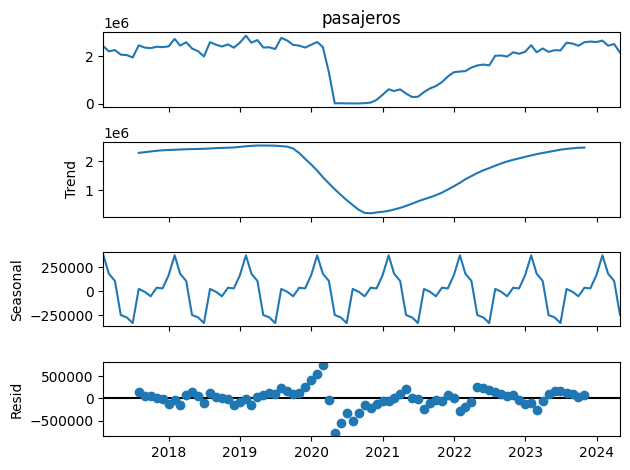

In [5]:
decomposition = seasonal_decompose(monthly_data['pasajeros'], model='additive')
decomposition.plot()
plt.show()

*II.- Vuelos.*

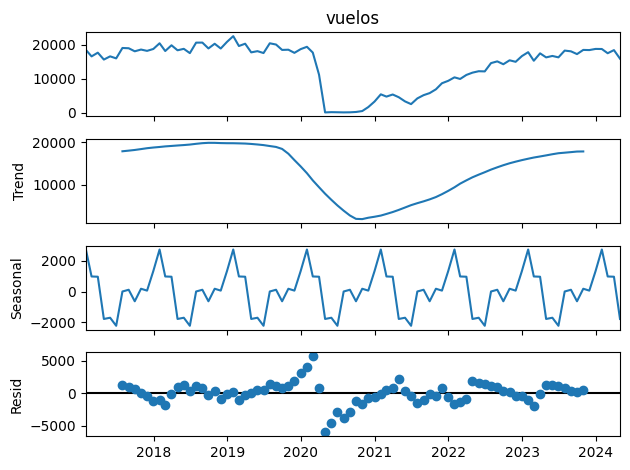

In [6]:
decomposition = seasonal_decompose(monthly_data['vuelos'], model='additive')
decomposition.plot()
plt.show()

De ambas decomposiciones se observa claramente la caída significativa en la tendencia alrededor del año 2020, coincidiendo con las restricciones de vuelos por la pandemia, y una recuperación que se inicia en 2021 y se estabiliza en 2022.</p>

La descomposición muestra:</p>

- Serie Original: La evolución de los pasajeros mensuales.</p>
- Tendencia (Trend): El cambio a largo plazo en los datos, donde se destaca la caída durante la pandemia y la posterior recuperación.</p>
- Estacionalidad (Seasonal): Fluctuaciones periódicas, que parecen tener un patrón anual, con picos y valles correspondientes a temporadas de mayor y menor actividad.</p>
- Residuos (Resid): Las variaciones no explicadas por la tendencia o la estacionalidad, que pueden considerarse como ruido.</p>

# **3.- MODELOS DE MACHINE LEARNING OPERATIONS.**

#### A.- REGRESIÓN LINEAL.

In [10]:
predicted_ocupacion, predicted_vuelos = regresion_lineal(DATABASEGENERAL)
print(f"Predicción para el 31 de diciembre de 2024:")
print(f"Ocupación: {predicted_ocupacion}")
print(f"Crecimiento de vuelos: {predicted_vuelos}")


Ocupación - R2: 0.008196684760576889, MSE: 33542.8277087737
Crecimiento de vuelos - R2: 0.00023483107370092515, MSE: 1.6350843838202638
Predicción para el 31 de diciembre de 2024:
Ocupación: [225.88916462]
Crecimiento de vuelos: [1.75509583]


c:\Users\LENOVO\Downloads\CONECTIVIDAD AÉREA\funciones.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATABASEGENERAL['fecha'] = pd.to_datetime(DATABASEGENERAL['fecha'])
c:\Users\LENOVO\Downloads\CONECTIVIDAD AÉREA\funciones.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATABASEGENERAL['dias'] = (DATABASEGENERAL['fecha'] - DATABASEGENERAL['fecha'].min()).dt.days
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-p

Los resultados del modelo de regresión lineal indican que la capacidad predictiva del modelo es muy baja para todas las variables:</p>

*Ocupación:*</p>

- R2: 0.008: Esto indica que el modelo apenas explica el 0.8% de la variabilidad en los datos de ocupación. Un R2 tan bajo sugiere que el modelo no es adecuado para predecir la ocupación.</p>
- MSE: 33542.83: El error cuadrático medio (MSE) es bastante alto, lo que implica que las predicciones están, en promedio, muy alejadas de los valores reales.</p>
- Predicción para el 31 de diciembre de 2024: [225.89]: Esta predicción parece inusualmente alta para un factor de ocupación, lo que refuerza la idea de que el modelo no es preciso.</p>

*Crecimiento de vuelos:*</p>

- R2: 0.0002: Este valor es extremadamente bajo, lo que indica que el modelo casi no tiene poder predictivo para el crecimiento de vuelos.</p>
- MSE: 1.64: Aunque el MSE es bajo, el R2 sugiere que el modelo apenas mejora la predicción sobre un promedio simple.</p>
- Predicción para el 31 de diciembre de 2024: [1.76]: Esta predicción parece más razonable en términos de magnitud, pero dada la baja calidad del ajuste (R2), es probable que no sea fiable.</p>


#### B.- REGRESIÓN POLINÓMICA.

In [11]:
resultados = regresion_polinomica(DATABASEGENERAL)

print(f"Predicción de pasajeros al 31-12-2024: {resultados['predicted_pasajeros']}")
print(f"Predicción de vuelos al 31-12-2024: {resultados['predicted_vuelos']}")

print(f"R2 (Entrenamiento) Pasajeros: {resultados['r2_train_pasajeros']}")
print(f"MSE (Entrenamiento) Pasajeros: {resultados['mse_train_pasajeros']}")
print(f"R2 (Prueba) Pasajeros: {resultados['r2_test_pasajeros']}")
print(f"MSE (Prueba) Pasajeros: {resultados['mse_test_pasajeros']}")

print(f"R2 (Entrenamiento) Vuelos: {resultados['r2_train_vuelos']}")
print(f"MSE (Entrenamiento) Vuelos: {resultados['mse_train_vuelos']}")
print(f"R2 (Prueba) Vuelos: {resultados['r2_test_vuelos']}")
print(f"MSE (Prueba) Vuelos: {resultados['mse_test_vuelos']}")


R2 (Entrenamiento) Pasajeros: 0.010139613197617914, MSE (Entrenamiento) Pasajeros: 33380.88787567794
R2 (Prueba) Pasajeros: 0.010610771045536205, MSE (Prueba) Pasajeros: 33461.183214259225
Predicción de pasajeros para el 31 de diciembre de 2024: 256.082001779803
R2 (Entrenamiento) Vuelos: 0.00539405138890392, MSE (Entrenamiento) Vuelos: 1.6101072540752488
R2 (Prueba) Vuelos: 0.005283029253207783, MSE (Prueba) Vuelos: 1.6268282150055347
Predicción de vuelos para el 31 de diciembre de 2024: 2.0644764055101374
Predicción de pasajeros al 31-12-2024: 256.082001779803
Predicción de vuelos al 31-12-2024: 2.0644764055101374
R2 (Entrenamiento) Pasajeros: 0.010139613197617914
MSE (Entrenamiento) Pasajeros: 33380.88787567794
R2 (Prueba) Pasajeros: 0.010610771045536205
MSE (Prueba) Pasajeros: 33461.183214259225
R2 (Entrenamiento) Vuelos: 0.00539405138890392
MSE (Entrenamiento) Vuelos: 1.6101072540752488
R2 (Prueba) Vuelos: 0.005283029253207783
MSE (Prueba) Vuelos: 1.6268282150055347


c:\Users\LENOVO\Downloads\CONECTIVIDAD AÉREA\funciones.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATABASEGENERAL['fecha'] = pd.to_datetime(DATABASEGENERAL['fecha'])
c:\Users\LENOVO\Downloads\CONECTIVIDAD AÉREA\funciones.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATABASEGENERAL['dias'] = (DATABASEGENERAL['fecha'] - DATABASEGENERAL['fecha'].min()).dt.days
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-p

Los resultados indican que el modelo de regresión polinómica tiene un rendimiento muy bajo para predecir tanto el número de pasajeros como el número de vuelos al 31 de diciembre de 2024. Los valores de 
𝑅
2 cercanos a 0, tanto en el conjunto de entrenamiento como en el conjunto de prueba, sugieren que el modelo no está capturando la relación entre las variables de entrada y las variables objetivo de manera efectiva. Los altos valores de MSE también indican que las predicciones tienen un error significativo.</p>

#### C.- MODELO FBPROPHET.

El presente modelo generará tres columnas clave para cada fecha predicha:</p>

- yhat: Es la predicción central o esperada de la cantidad de pasajeros para esa fecha.</p>
- yhat_lower y yhat_upper: Son los límites inferior y superior del intervalo de confianza para la predicción. Estos valores indican el rango dentro del cual se espera que se encuentre la verdadera cantidad de pasajeros, con un cierto nivel de confianza (normalmente el 80% o 95%, dependiendo de la configuración de Prophet).</p>

El ancho del intervalo de confianza (yhat_upper - yhat_lower) proporciona una medida de la incertidumbre en la predicción. Un intervalo más estrecho indica mayor confianza en la predicción, mientras que un intervalo más amplio indica mayor incertidumbre.</p>

*I.- Pasajeros.*

In [9]:
predecir_pasajeros_prophet(DATABASEGENERAL, periods=8)

20:18:19 - cmdstanpy - INFO - Chain [1] start processing
20:18:19 - cmdstanpy - INFO - Chain [1] done processing


           ds          yhat     yhat_lower    yhat_upper
88 2024-05-31  1.027069e+06  -54311.123958  2.099612e+06
89 2024-06-30  1.197815e+06  156395.040421  2.304713e+06
90 2024-07-31  1.489358e+06  469706.115727  2.581447e+06
91 2024-08-31  1.658448e+06  605052.753081  2.751880e+06
92 2024-09-30  1.692141e+06  623720.587397  2.721419e+06
93 2024-10-31  1.623701e+06  551269.190635  2.672299e+06
94 2024-11-30  1.510296e+06  477832.520505  2.606819e+06
95 2024-12-31  1.443518e+06  380723.856195  2.492504e+06


,ds,yhat,yhat_lower,yhat_upper
88,2024-05-31,1.027069e+06,-54311.123958,2.099612e+06
89,2024-06-30,1.197815e+06,156395.040421,2.304713e+06
90,2024-07-31,1.489358e+06,469706.115727,2.581447e+06
91,2024-08-31,1.658448e+06,605052.753081,2.751880e+06
92,2024-09-30,1.692141e+06,623720.587397,2.721419e+06
93,2024-10-31,1.623701e+06,551269.190635,2.672299e+06
94,2024-11-30,1.510296e+06,477832.520505,2.606819e+06
95,2024-12-31,1.443518e+06,380723.856195,2.492504e+06


Para el 31 de diciembre de 2024, la predicción central (yhat) es de 1.443.518 pasajeros.</p>
El intervalo de confianza está entre 371.027 (yhat_lower) y 2.448.509 (yhat_upper).</p>
Esto significa que, según el modelo Prophet, el número de pasajeros el 31 de diciembre de 2024 podría estar en cualquier lugar entre 371.027 y 2.448.509, pero lo más probable es que esté alrededor de 1.443.518.</p>

*II.- Vuelos.*

In [10]:
predecir_vuelos_prophet(DATABASEGENERAL, periods=8)

20:18:23 - cmdstanpy - INFO - Chain [1] start processing
20:18:23 - cmdstanpy - INFO - Chain [1] done processing


           ds          yhat   yhat_lower    yhat_upper
88 2024-05-31   7331.497170  -156.580719  14641.049924
89 2024-06-30   8516.897691   517.890684  16548.834510
90 2024-07-31  10521.438763  2749.618303  18456.001322
91 2024-08-31  11929.205512  4029.654193  20164.254134
92 2024-09-30  11826.168524  4292.005787  20104.882104
93 2024-10-31  11290.412190  3466.506571  19249.119076
94 2024-11-30  10592.023188  2900.502581  17939.701071
95 2024-12-31   9996.227405  2544.926083  17569.106079


,ds,yhat,yhat_lower,yhat_upper
88,2024-05-31,7331.497170,-156.580719,14641.049924
89,2024-06-30,8516.897691,517.890684,16548.834510
90,2024-07-31,10521.438763,2749.618303,18456.001322
91,2024-08-31,11929.205512,4029.654193,20164.254134
92,2024-09-30,11826.168524,4292.005787,20104.882104
93,2024-10-31,11290.412190,3466.506571,19249.119076
94,2024-11-30,10592.023188,2900.502581,17939.701071
95,2024-12-31,9996.227405,2544.926083,17569.106079


Para el 31 de diciembre de 2024, la predicción central (yhat) es de 9.996 vuelos.</p>
El intervalo de confianza está entre 2.544 (yhat_lower) y 17.569 (yhat_upper).</p>
Esto significa que, según el modelo Prophet, el número de vuelos el 31 de diciembre de 2024 podría estar en cualquier lugar entre 2.544 y 17.569.509, pero lo más probable es que esté alrededor de 9.996.</p>

*III.- Pasajeros por aerolíneas.*

In [11]:
predecir_pasajeros_aerolineas(DATABASEGENERAL, periods=8)

20:18:27 - cmdstanpy - INFO - Chain [1] start processing
20:18:27 - cmdstanpy - INFO - Chain [1] done processing
20:18:27 - cmdstanpy - INFO - Chain [1] start processing
20:18:27 - cmdstanpy - INFO - Chain [1] done processing
20:18:27 - cmdstanpy - INFO - Chain [1] start processing
20:18:28 - cmdstanpy - INFO - Chain [1] done processing
20:18:28 - cmdstanpy - INFO - Chain [1] start processing
20:18:28 - cmdstanpy - INFO - Chain [1] done processing
20:18:28 - cmdstanpy - INFO - Chain [1] start processing
20:18:28 - cmdstanpy - INFO - Chain [1] done processing
20:18:28 - cmdstanpy - INFO - Chain [1] start processing
20:18:29 - cmdstanpy - INFO - Chain [1] done processing
20:18:29 - cmdstanpy - INFO - Chain [1] start processing
20:18:29 - cmdstanpy - INFO - Chain [1] done processing
20:18:29 - cmdstanpy - INFO - Chain [1] start processing
20:18:29 - cmdstanpy - INFO - Chain [1] done processing
20:18:29 - cmdstanpy - INFO - Chain [1] start processing
20:18:29 - cmdstanpy - INFO - Chain [1]

,ds,aerolinea,yhat,yhat_lower,yhat_upper
0,2017-01-31,Aerolíneas Argentinas,1.045221e+06,580644.193247,1.522934e+06
1,2017-02-28,Aerolíneas Argentinas,1.046708e+06,550297.417750,1.539322e+06
2,2017-03-31,Aerolíneas Argentinas,9.987292e+05,533568.058359,1.451707e+06
3,2017-04-30,Aerolíneas Argentinas,8.288137e+05,351621.209185,1.306030e+06
4,2017-05-31,Aerolíneas Argentinas,7.437661e+05,263976.726705,1.195573e+06
...,...,...,...,...,...
91,2024-08-31,Sky Airline,2.715026e+04,9527.170278,4.555161e+04
92,2024-09-30,Sky Airline,2.661454e+04,8987.918135,4.525607e+04
93,2024-10-31,Sky Airline,2.724751e+04,8550.679103,4.500164e+04
94,2024-11-30,Sky Airline,2.692422e+04,7546.348575,4.393342e+04


*IV.- Vuelos por aerolíneas.*

In [12]:
predecir_vuelos_aerolineas(DATABASEGENERAL, periods=8)

20:18:34 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing
20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing
20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing
20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:36 - cmdstanpy - INFO - Chain [1] done processing
20:18:36 - cmdstanpy - INFO - Chain [1] start processing
20:18:36 - cmdstanpy - INFO - Chain [1] done processing
20:18:36 - cmdstanpy - INFO - Chain [1] start processing
20:18:36 - cmdstanpy - INFO - Chain [1] done processing
20:18:36 - cmdstanpy - INFO - Chain [1] start processing
20:18:36 - cmdstanpy - INFO - Chain [1] done processing
20:18:37 - cmdstanpy - INFO - Chain [1] start processing
20:18:37 - cmdstanpy - INFO - Chain [1] done processing
20:18:37 - cmdstanpy - INFO - Chain [1] start processing
20:18:37 - cmdstanpy - INFO - Chain [1]

,ds,aerolinea,yhat,yhat_lower,yhat_upper
0,2017-01-31,Aerolíneas Argentinas,9818.657521,5570.284452,13951.349427
1,2017-02-28,Aerolíneas Argentinas,9890.368099,5933.320107,14290.309018
2,2017-03-31,Aerolíneas Argentinas,9821.511710,5528.152391,13753.123222
3,2017-04-30,Aerolíneas Argentinas,8128.854993,4132.350250,11988.491207
4,2017-05-31,Aerolíneas Argentinas,7579.624450,3249.131634,11909.519258
...,...,...,...,...,...
91,2024-08-31,Sky Airline,160.361644,36.837734,290.846108
92,2024-09-30,Sky Airline,157.054425,28.503378,300.980772
93,2024-10-31,Sky Airline,158.525895,19.906909,291.991101
94,2024-11-30,Sky Airline,162.023401,31.544236,291.503468
